In [35]:
import os
import collections
import json
import pickle
from tqdm import tqdm
from natsort import natsorted

from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
# pd.set_option('display.max_columns', 500)
# pd.options.display.max_rows = 500
# pd.options.display.max_columns = 20
# pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.min_rows', 100)
# pd.set_option('display.expand_frame_repr', True)

# import matplotlib.pyplot as plt
# import seaborn as sns

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from src.wimbd_ import _load_dataset, WimbdTasks, filter_percentile
wt = WimbdTasks()

In [2]:
percentile = 0.99
TASK = 'en-fr'
LANG_COLS = 'fr'
LANG_COL_COMMON = 'lang_2'
LANG_COL_ALL = 'fr'
LANG_COL = 'fr'
VALUE_COL = 'value' # 'value_diff'
NAME = 'log(en, fr), p=0.9'  # - log(p_en")'

model = 'EleutherAI/pythia-12b'
tokenizer = AutoTokenizer.from_pretrained(model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
import glob

def load_logits(logits_pth):
    logit_dict = {}
    all_pths = sorted(glob.glob(os.path.join(logits_pth, "**/*.pt"), recursive=True))
    for pth in tqdm(all_pths):
        logits = torch.load(pth)
        id_ = int(pth.split("_")[-1].split(".")[0])
        logit_dict[id_] = logits
        # print(f"id: {id_}, logits shape: {logits.shape}")
    return logit_dict

def load_tokens(tokens_path):
    token_dict = {}
    all_paths = sorted(glob.glob(os.path.join(tokens_path, "**/*.json"), recursive=True))
    
    for path in tqdm(all_paths):
        with open(path, 'r') as f:
            logits = json.load(f)
        
        id_ = int(path.split("_")[-1].split(".")[0])
        token_dict[id_] = logits
        # print(f"id: {id_}, number of logits: {len(logits)}")
    
    return token_dict


# model_results_pth =  "./models/pythia/debug"
model_results_pth = f"./models/experiment_6_logits_max_5/inference/EleutherAI/pythia-12b/TRANSLATION/wmt09-{TASK}/0-shot"
model_logits_pth = os.path.join(model_results_pth, "logits")
model_tokens_pth = os.path.join(model_results_pth, "tokens")
model_logits = load_logits(model_logits_pth)
model_tokens = load_tokens(model_tokens_pth)
doc_results = json.load(open(os.path.join(model_results_pth, "doc_results.json"), 'r'))
doc_results = doc_results[list(doc_results.keys())[0]]

 14%|█▍        | 429/3027 [00:00<00:02, 996.00it/s] 

100%|██████████| 3027/3027 [00:02<00:00, 1283.44it/s]


In [4]:
# examples_pth = "./results/n-grams/exp_full/2/examples_dfs_0-shot_common_models.pkl"
# Common
# examples_pth = "./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/2/common/lang_dfs_filter_charsFalse_percentile0.999_n_gram2.pkl"
# All
# examples_pth = "./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/all/lang_dfs_filter_charsFalse_percentile0.95.pkl"
# europarl
# All
examples_pth_all = "./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/all/lang_dfs_is_allTrue_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue.pkl"
# examples_pth_all = "./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/all/lang_dfs_is_allTrue_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue_filter_stopwordsTrue.pkl"
# examples_pth_all = "./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/all/lang_dfs_is_allTrue_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue_filter_stopwordsFalse_remove_englishFalse_remove_non_englishTrue.pkl"
examples_all = pickle.load(open(examples_pth_all, "rb"))['en-fr']
examples_all = filter_percentile(examples_all, 0.9)

# common
examples_pth_common = "./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/common/lang_dfs_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue_align_langs0.pkl"
# examples_pth_common = "./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/all/lang_dfs_is_allTrue_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue_filter_stopwordsTrue.pkl"
# examples_pth_common = "./incidental-supervision/results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/common/lang_dfs_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue_filter_stopwordsTrue_align_langs0.pkl"
examples_common = pickle.load(open(examples_pth_common, "rb"))['en-fr']
examples_common = filter_percentile(examples_common, 0.975)

# df = pickle.load(open(examples_pth, "rb"))

# # df_12b = df['pythia-12b']
# # df_fr_en = df_12b[df_12b['task'] == 'fr-en']
# df = df['en-fr']
# df = filter_percentile(df, percentile)
# df.head(2)

In [5]:
examples_all.head()

,fr,value,example,task,example_clean,sequence,coverage
0,Budgets on,17518,"{'translation': {'en': 'On the whole, I think ...",en-fr,"On the whole, I think that the report submitte...",Budgets on,0.999327
2,Le pire,17512,{'translation': {'en': 'The worst risk is to t...,en-fr,The worst risk is to take no risks. Le pire de...,Le pire,0.999327
1,de fruits,17512,"{'translation': {'en': 'First, does the Europe...",en-fr,"First, does the European Union need to produce...",de fruits,0.999327
3,choses se,17508,{'translation': {'en': 'I fully appreciate tha...,en-fr,I fully appreciate that the Irish Government a...,choses se,0.999327
4,pays avec,17507,"{'translation': {'en': 'Russia, however, is no...",en-fr,"Russia, however, is not the USSR. Mais la Russ...",pays avec,0.999327


In [6]:
examples_common.head()

,lang_1,lang_2,value,example,task,pair,example_clean,coverage
0,you have,vous êtes,21696,{'translation': {'en': 'The report you have be...,en-fr,"(you have, vous êtes)",The report you have before you today is signif...,0.765278
1,we all,nous sommes,21696,{'translation': {'en': 'We all worked very har...,en-fr,"(we all, nous sommes)",We all worked very hard to achieve a balance b...,0.765278
2,are the,tous les,21694,{'translation': {'en': 'We consider it a miles...,en-fr,"(are the, tous les)",We consider it a milestone in the process of E...,0.765278
3,majority in,large part,21693,{'translation': {'en': 'A large majority in ou...,en-fr,"(majority in, large part)",A large majority in our group wants to reject ...,0.765278
4,to these,à ces,21692,{'translation': {'en': 'I therefore believe - ...,en-fr,"(to these, à ces)",I therefore believe - and here I am addressing...,0.765278


In [7]:
def subtract_values(df1, df2, col1, col2, value_col):
    # Merge the two DataFrames based on the specified columns
    merged_df = pd.merge(df1, df2, left_on=col1, right_on=col2, suffixes=('_1', '_2'), how='left')
    
    # Subtract the values from df2 from df1 where the specified columns match
    merged_df[value_col + '_diff'] = merged_df[value_col + '_1'] - merged_df[value_col + '_2']
    
    # Calculate the average difference for the values that have matches
    avg_diff = merged_df[value_col + '_diff'].mean()
    
    # Fill the missing values in the '_diff' column with the average difference
    merged_df[value_col + '_diff'].fillna(avg_diff, inplace=True)
    
    # For the values that have no matches, subtract the average difference from the original value
    merged_df.loc[merged_df[value_col + '_2'].isna(), value_col + '_diff'] = merged_df[value_col + '_1'] - avg_diff
    
    return merged_df

examples_diff = subtract_values(examples_all, examples_common, LANG_COL_ALL, LANG_COL_COMMON, 'value')
df = examples_common

In [8]:
# test_logits(model_logits, doc_results, tokenizer, model_tokens)

In [9]:
# calculate ngram distribution

ngram_counts = df.groupby(LANG_COL_COMMON)['value'].sum()
n_gram_dist = (ngram_counts / ngram_counts.sum()).astype(float)
n_gram_dist = n_gram_dist[n_gram_dist > 0]
n_gram_log_dist = np.log(n_gram_dist).reset_index()


# calculate ngram distribution
def calc_ngram_dist(df, lang_col, value_col):
    ngram_counts = df.groupby(lang_col)[value_col].sum()
    n_gram_dist = (ngram_counts / ngram_counts.sum()).astype(float)
    n_gram_dist = n_gram_dist[n_gram_dist > 0]
    n_gram_dist = np.log(n_gram_dist)
    return n_gram_dist

n_gram_dist_all = calc_ngram_dist(examples_all, LANG_COL_ALL, VALUE_COL)
n_gram_dist_common = calc_ngram_dist(examples_common, LANG_COL_COMMON, VALUE_COL)
# n_gram_dist = calc_ngram_dist(df, LANG_COL_COMMON, VALUE_COL)

# subtract ngram log dist all from common
n_gram_dist_all_ = n_gram_dist_all.reset_index(name='log_prob')
n_gram_dist_common_ = n_gram_dist_common.reset_index(name='log_prob')
log_prob_col = 'log_prob'
n_gram_dist_diff = subtract_values(n_gram_dist_common_, n_gram_dist_all_, LANG_COL_COMMON, LANG_COL_ALL, log_prob_col)
n_gram_dist_diff.dropna(subset=[log_prob_col + '_diff'], inplace=True)
n_gram_dist_diff.reset_index(inplace=True)

VALUE_COL_DIST= log_prob_col + '_diff'


n_gram_log_dist = n_gram_log_dist.reset_index().rename(columns={'index': 'lang_2'})

In [10]:
examples_common.head(2)

,lang_1,lang_2,value,example,task,pair,example_clean,coverage
0,you have,vous êtes,21696,{'translation': {'en': 'The report you have be...,en-fr,"(you have, vous êtes)",The report you have before you today is signif...,0.765278
1,we all,nous sommes,21696,{'translation': {'en': 'We all worked very har...,en-fr,"(we all, nous sommes)",We all worked very hard to achieve a balance b...,0.765278


In [11]:
def calc_ngram_dist_factorized(df_1, df_2, lang_col_1, lang_col_2):
    df_1['dist'] = df_1['value'] / df_1['value'].sum()
    df_1 = df_1[df_1['dist'] > 0]

    df_2['dist'] = df_2['value'] / df_2['value'].sum()
    df_2 = df_2[df_2['dist'] > 0]

    # Replace zero values with a small positive value (e.g., 1e-8)
    df_1['dist'].replace(0, 1e-8, inplace=True)
    df_2['dist'].replace(0, 1e-8, inplace=True)

    # Ensure no NaN or inf values before taking log
    df_1['dist'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_2['dist'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_1.dropna(subset=['dist'], inplace=True)
    df_2.dropna(subset=['dist'], inplace=True)

    df_1['log_dist'] = np.log(df_1['dist'])
    df_2['log_dist'] = np.log(df_2['dist'])

    df_1 = subtract_values(df_1, df_2, lang_col_1, lang_col_2, 'log_dist')

    return df_1

df_common_factorized = calc_ngram_dist_factorized(examples_common, examples_all, LANG_COL_COMMON, LANG_COL_ALL)
VALUE_COL_DIST = 'log_dist_diff'
df_common_factorized.head(1)

,lang_1,lang_2,value_1,example_1,task_1,pair,example_clean_1,coverage_1,dist_1,log_dist_1,fr,value_2,example_2,task_2,example_clean_2,sequence,coverage_2,dist_2,log_dist_2,log_dist_diff
0,you have,vous êtes,21696,{'translation': {'en': 'The report you have be...,en-fr,"(you have, vous êtes)",The report you have before you today is signif...,0.765278,0.000096,-9.251912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.655587


In [12]:
n_gram_dist_common_.head(1)

,lang_2,log_prob
0,A ce,-10.435778


In [13]:
examples_common.head(1)

,lang_1,lang_2,value,example,task,pair,example_clean,coverage,dist
0,you have,vous êtes,21696,{'translation': {'en': 'The report you have be...,en-fr,"(you have, vous êtes)",The report you have before you today is signif...,0.765278,0.000096


In [14]:
examples_common.groupby('lang_2')['value'].sum()

lang_2
A ce           6641
A cet          2857
A mon          7986
A notre        1482
A plutôt         89
               ... 
œuvre un         37
œuvre à        1212
œuvrer avec       2
œuvrer en         1
Špidla a          1
Name: value, Length: 56622, dtype: object

In [15]:
# doc_results, model_logits, model_tokens

result_1 = doc_results[0]
logit_1 = model_logits[result_1['id']]
tokens_1 = model_tokens[result_1['id']][0]

print(result_1)
print(logit_1.shape)
print(len(tokens_1))

"""
1. break down the generation into all possible ngrams
2. search for each possible ngram in the n_gram_log_dist
3. pick the ones with the highest probability. make sure
   no ngrams overlap in the chosen set
4. match the chosen ngrams, to the tokens and their associated
   logits
"""

{'src': 'In New York, Wall Street opened with significant losses.', 'ref': 'À New-York, Wall Street ouvrait avec des pertes sensibles.', 'result': [' Dans New York, Wall Street a ouvert avec des pertes significatives.'], 'id': 0}
torch.Size([1, 17])
17


'\n1. break down the generation into all possible ngrams\n2. search for each possible ngram in the n_gram_log_dist\n3. pick the ones with the highest probability. make sure\n   no ngrams overlap in the chosen set\n4. match the chosen ngrams, to the tokens and their associated\n   logits\n'

In [16]:
n_gram_log_dist.head(2)

,lang_2,lang_2,value
0,0,A ce,-10.435778
1,1,A cet,-11.279268


In [17]:
n_gram_dist_common_

,lang_2,log_prob
0,A ce,-10.435778
1,A cet,-11.279268
2,A mon,-10.251350
3,A notre,-11.935648
4,A plutôt,-14.748159
...,...,...
56617,œuvre un,-15.625877
56618,œuvre à,-12.136768
56619,œuvrer avec,-18.543648
56620,œuvrer en,-19.236795


In [18]:
examples_pth_all

'./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/all/lang_dfs_is_allTrue_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue.pkl'

In [19]:
doc_results[0]

{'src': 'In New York, Wall Street opened with significant losses.',
 'ref': 'À New-York, Wall Street ouvrait avec des pertes sensibles.',
 'result': [' Dans New York, Wall Street a ouvert avec des pertes significatives.'],
 'id': 0}

In [111]:
def generate_ngrams(text, n):
    words = text.split()
    ngrams = []
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i+n])
        ngrams.append(ngram)
    return ngrams

def find_ngrams_in_dist(ngrams, n_gram_log_dist, col_name, lang_col):
    ngram_probs = []
    lang_col = lang_col if lang_col in n_gram_log_dist.columns else 'lang_2'
    for ngram in ngrams:
        # print(ngram)
        if ngram in list(n_gram_log_dist[lang_col]):
            # print("found")
            prob = n_gram_log_dist[n_gram_log_dist[lang_col] == ngram][col_name].values[0]
            ngram_probs.append((ngram, prob))
    return ngram_probs

def pick_nonoverlapping_ngrams(ngram_probs):
    ngram_probs.sort(key=lambda x: x[1], reverse=True)
    chosen_ngrams = []
    for ngram, prob in ngram_probs:
        if not any(ngram in chosen_ngram for chosen_ngram in chosen_ngrams):
            chosen_ngrams.append(ngram)
    return chosen_ngrams

def match_ngrams_to_probs(chosen_ngrams, tokens, probs, tokenizer):
    ngram_probs = []
    for ngram in chosen_ngrams:
        ngram_tokens = tokenizer.encode(ngram)
        # token_indices = [tokens.index(token) for token in ngram_tokens]
        token_indices = []
        # print(tokens)
        for token in ngram_tokens:
            if token in tokens:
                # print(f"token found!")
                token_indices.append(tokens.index(token))
            else:
                # print(f"Token {token} not found in tokens")
                continue
        # assert len(token_indices) == len(ngram_tokens), f"Token indices: {token_indices}, ngram tokens: {ngram_tokens}"
        # assert token_indices <= len(tokens), f"Token indices: {token_indices}, tokens: {tokens}"
        ngram_logit = probs[token_indices].mean()
        ngram_probs.append((ngram, ngram_logit.item()))
    # if len(ngram_probs) == 0:
        # print(f"No ngrams found in tokens")
    return ngram_probs

def process_doc_results(doc_results, model_tokens, model_probs, 
                        tokenizer, n_gram_log_dist, value_col, n_iters=None,
                        save_pth=None):
    if n_iters is None:
        n_iters = len(doc_results)
    
    for i in tqdm(range(n_iters)):
        result = doc_results[i]
        generation = result['result'][0]
        tokens = model_tokens[result['id']][0]
        probs = model_probs[result['id']][0]
        
        ngrams = generate_ngrams(generation, n=2)
        ngram_ds_probs = find_ngrams_in_dist(ngrams, n_gram_log_dist, 
                                             value_col, LANG_COL)
        chosen_ngrams = pick_nonoverlapping_ngrams(ngram_ds_probs)
        ngram_lm_probs = match_ngrams_to_probs(chosen_ngrams, tokens, probs, tokenizer)
        
        # save results
        doc_results[i]['ngram_ds_probs'] = ngram_ds_probs
        doc_results[i]['ngram_lm_probs'] = ngram_lm_probs
        doc_results[i]['chosen_ngrams'] = chosen_ngrams
    
    if save_pth is not None:
        with open(save_pth, 'w') as f:
            json.dump(doc_results, f)
    
    return doc_results

def create_ngram_dataframe(doc_results_new):
    data = []

    for row in doc_results_new:
        chosen_ngrams = row['chosen_ngrams']
        ngram_ds_probs = row['ngram_ds_probs']
        ngram_lm_probs = row['ngram_lm_probs'] if 'ngram_lm_probs' in row else row['ngram_lm_logits']
        
        for ngram, ds_prob, lm_logit in zip(chosen_ngrams, ngram_ds_probs, ngram_lm_probs):
            data.append({
                'ngrams': ngram,
                'ds_probs': ds_prob[1],
                'lm_probs': lm_logit[1]
            })

    df = pd.DataFrame(data)

    # if there's more than one
    # entry for an ngram, take the mean
    df = df.groupby('ngrams').mean().reset_index()
    
    df['lm_probs'] = np.log(df['lm_probs'])
    return df

from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr

def calculate_similarity(lm_probs, ds_probs, method='kl_divergence'):
    """
    Calculate the similarity between two probability distributions.
    'lm_probs' and 'ds_probs' should be lists of probabilities for each ngram.
    """
    # Normalize the probabilities
    lm_probs = np.array(lm_probs)
    ds_probs = np.array(ds_probs)
    lm_probs_normalized = lm_probs / lm_probs.sum()
    ds_probs_normalized = ds_probs / ds_probs.sum()
    
    # Choose the method to calculate similarity
    if method == 'kl_divergence':
        # Calculate the Jensen-Shannon divergence, which is the symmetrized and smoothed version of KL divergence
        similarity = jensenshannon(lm_probs_normalized, ds_probs_normalized)
    elif method == 'correlation':
        # Calculate the Pearson correlation coefficient
        correlation, _ = pearsonr(lm_probs_normalized, ds_probs_normalized)
        similarity = correlation
    elif method == 'mse':
        similarity = mean_squared_error(lm_probs_normalized, ds_probs_normalized)
    elif method == 'cross_entropy':
        similarity = -np.sum(ds_probs_normalized * np.log(lm_probs_normalized))
    else:
        raise ValueError("Unsupported method for similarity calculation.")
    
    return similarity

def create_prob_seq_df(doc_results_new):
    data = []
    
    for row in doc_results_new:
        chosen_ngrams = row['chosen_ngrams']
        ngram_ds_probs = dict(row['ngram_ds_probs'])
        ngram_lm_probs = dict(row['ngram_lm_probs'] if 'ngram_lm_probs' in row else row['ngram_lm_logits'])
        len_ngrams = len(ngram_ds_probs)
        len_probs = len(ngram_lm_probs) 

        ds_probs = [ngram_ds_probs[ngram] for ngram in chosen_ngrams]
        lm_probs = [ngram_lm_probs[ngram] for ngram in chosen_ngrams]

        lm_probs_kldiv = calculate_similarity(np.log(lm_probs), ds_probs, method='kl_divergence')
        # lm_probs_corr = calculate_similarity(lm_probs, ds_probs, method='correlation')
        if len_ngrams and len_probs > 0:
            lm_probs_mse = calculate_similarity(lm_probs, ds_probs, method='mse')
            lm_probs_cross_entropy = calculate_similarity(lm_probs, ds_probs, method='cross_entropy')
        
        data.append({
            'example': row['result'][0],
            'id': row['id'],
            'ngrams': chosen_ngrams,
            'ds_probs': ds_probs,
            'ds_probs_sum': np.sum(ds_probs),
            'ds_probs_mean': np.mean(ds_probs),
            'lm_probs': lm_probs,
            'lm_probs': np.log(lm_probs),
            'lm_probs_sum': np.sum(np.log(lm_probs)),
            'lm_probs_mean': np.mean(np.log(lm_probs)),
            'len_ngrams': len_ngrams,
            'len_probs': len_probs,
            'lm_probs_kldiv': lm_probs_kldiv,
            # 'lm_probs_corr': lm_probs_corr
            'lm_probs_mse': lm_probs_mse,
            'lm_probs_cross_entropy': lm_probs_cross_entropy
        })
    
    return pd.DataFrame(data).dropna()

In [113]:
tokenizer = AutoTokenizer.from_pretrained(model)
model_probs = model_logits
doc_pth = os.path.dirname(examples_pth_common) + f"/doc_results_ngrams_{NAME}.json"
# if os.path.exists(doc_pth):
#     doc_results_new = json.load(open(doc_pth, 'r'))
# else:
# doc_results_new = process_doc_results(doc_results, model_tokens, model_probs, 
#                                             tokenizer, n_gram_dist_common_, 'log_prob',
#                                             n_iters=None, save_pth=doc_pth)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [114]:
n_gram_dist_all_

,fr,log_prob
0,A cet,-9.824516
1,A cette,-9.929010
2,A juste,-10.675181
3,A mon,-9.738760
4,A ou,-10.241883
...,...,...
92916,œuvrons tous,-16.099816
92917,œuvré ensemble,-16.253967
92918,œuvré pour,-11.936478
92919,Šefčovič de,-15.443036


In [115]:
n_gram_dist_common_

,lang_2,log_prob
0,A ce,-10.435778
1,A cet,-11.279268
2,A mon,-10.251350
3,A notre,-11.935648
4,A plutôt,-14.748159
...,...,...
56617,œuvre un,-15.625877
56618,œuvre à,-12.136768
56619,œuvrer avec,-18.543648
56620,œuvrer en,-19.236795


In [116]:
# else:
#     doc_results_new = json.load(open(doc_pth, 'r'))
df = create_ngram_dataframe(doc_results_new)
df_examples = create_prob_seq_df(doc_results_new)

/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid valu

/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/antonis/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid valu

In [117]:
df_examples

,example,id,ngrams,ds_probs,ds_probs_sum,ds_probs_mean,lm_probs,lm_probs_sum,lm_probs_mean,len_ngrams,len_probs,lm_probs_kldiv,lm_probs_mse,lm_probs_cross_entropy
0,"Dans New York, Wall Street a ouvert avec des ...",0,"[avec des, a ouvert, des pertes]","[-7.334859398599686, -13.342392499341267, -13....",-34.197020,-11.399007,"[-0.47784680670676144, -0.1382859813604522, -0...",-0.642102,-0.214034,3,3,0.417067,0.000912,1.069040
1,"Dans trois groupes, cette maladie est expérim...",1,"[à la, parmi les, de manière, les personnes, e...","[-5.6990561219851115, -7.934035498659843, -8.2...",-167.334338,-11.952453,"[-0.13297351255426554, -0.07185690194525098, -...",-2.663055,-0.190218,14,14,0.294331,0.000410,2.641826
2,"Si vous êtes un écouteur plus exigeant, prene...",2,"[vous êtes, Si vous, êtes un, téléphones porta...","[-6.77179895082495, -7.789059268215552, -11.78...",-41.459563,-10.364891,"[-0.037308480136783055, -0.0661022431137539, -...",-0.294011,-0.073503,4,4,0.044500,0.007417,1.394339
3,Les marchés financiers ont baissé de 7 % à 99...,3,"[sur le, marchés financiers]","[-5.033611677476293, -10.42977237768064]",-15.463384,-7.731692,"[-0.8469723925242817, -0.34208695584666265]",-1.189059,-0.594530,2,2,0.277335,0.002588,0.636585
4,"Quand un rat est en danger, il fait la même c...",4,"[de la, est en, la même, chose que, même chose...","[-5.4694482362309955, -5.901862514250117, -7.1...",-80.707809,-8.967534,"[-0.6188299669058959, -0.2955252499128068, -0....",-2.567365,-0.285263,9,9,0.313963,0.001857,2.227680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3021,`Il pourrait y avoir de la matière noire qui ...,3021,"[de la, y avoir, pourrait être, être à, près d...","[-5.4694482362309955, -8.04319397842407, -8.32...",-107.229248,-9.748113,"[-0.14306328424988224, -0.010800301350769714, ...",-3.381189,-0.307381,11,11,0.344595,0.001261,2.449381
3023,Avalon Bay annoncé il y a quelques mois qu'il...,3023,"[il y, y a, par un, pour être, y compris, a qu...","[-5.371028068325082, -6.309255336138713, -7.26...",-124.488741,-10.374062,"[-0.18417874905837717, -0.011294006618758888, ...",-3.584423,-0.298702,12,12,0.349919,0.001136,2.525674
3024,"Deux extrêmes, entre lesquels il y a assez de...",3024,"[il y, tout le, y a, pour tout, lesquels il, p...","[-5.371028068325082, -5.933982150040631, -6.30...",-51.891797,-8.648633,"[-0.3316013063866164, -0.0053855699325925845, ...",-1.201806,-0.200301,6,6,0.391042,0.004153,1.816712
3025,Une jeune femme de stewardesse de la région d...,3025,"[sur le, dans un, de la, pour la, la région, q...","[-5.033611677476293, -5.353667249508869, -5.46...",-76.427994,-8.491999,"[-0.7188657098479344, -0.22767038353838454, -0...",-3.372674,-0.374742,9,9,0.304384,0.000855,2.164780


In [118]:
total_set = set()  # Use a set instead of a tuple to store unique ngrams

for row in doc_results_new:
    chosen_ngrams = row['chosen_ngrams']
    for chosen in chosen_ngrams:
        total_set.add(chosen)  # Add each chosen ngram to the set

print(f"total_set: {len(total_set)}")

total_set: 8438


In [119]:
def fit_and_evaluate_linear_regression(df, column_1, column_2,
                                       test_size=0.2, random_state=42,
                                       save_pth=None, title='Linear Regression'):
    
    # Ensure 'len_ngrams' is in the DataFrame and is not the target or a feature
    if 'len_ngrams' not in df:
        raise ValueError("The DataFrame does not contain the 'len_ngrams' column.")

    len_min, len_max = -3, 0
    df = df[(df[column_2] >= len_min) & (df[column_2] <= len_max)]

    # Split the data into training and testing sets
    X = df[[column_1]]  # Independent variable
    y = df[column_2]    # Dependent variable
    len_ngrams = df['len_ngrams']  # This column is just for plotting purposes, not for training
    X_train, X_test, y_train, y_test, len_ngrams_train, len_ngrams_test = train_test_split(
        X, y, len_ngrams, test_size=test_size, random_state=random_state
    )

    # Fit the linear regression model on the training set
    model = LinearRegression()
    model.fit(X_train, y_train)
    coeff = model.coef_

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation metrics
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R^2):", r2)

    # Add the predicted values to the testing set DataFrame
    df_test = X_test.copy()
    df_test[column_2] = y_test
    df_test['predicted'] = y_pred
    df_test['len_ngrams'] = len_ngrams_test  # Add the len_ngrams for plotting

    # Normalize len_ngrams for color mapping
    len_ngrams_normalized = (len_ngrams_test - len_ngrams_test.min()) / (len_ngrams_test.max() - len_ngrams_test.min())

    # Create a colormap
    cmap = cm.get_cmap('viridis')

    stats = {
        'mse': mse,
        'r2': r2
    }

    save_title = title.replace(' ', '_')
    if save_pth is not None:
        with open(os.path.join(save_pth, f'{save_title}.json'), 'w') as f:
            print(os.path.join(save_pth, f'{save_title}.json'))
            json.dump(stats, f)
        print(f"Stats saved to {save_pth}")

    # Calculate the mean and standard deviation of y
    y_mean = np.mean(y_test)
    y_std = np.std(y_test)

    # Filter the points within 2 standard deviations
    mask = np.abs(y_test - y_mean) <= 2 * y_std
    X_test_filtered = X_test[mask]
    y_test_filtered = y_test[mask]
    y_pred_filtered = y_pred[mask]
    len_ngrams_normalized_filtered = len_ngrams_normalized[mask]

    plt.figure(figsize=(6, 5.5))  # Set the figure size to be square

    # Use the normalized len_ngrams for the color mapping
    scatter = plt.scatter(X_test_filtered, y_test_filtered, 
                          c=cmap(len_ngrams_normalized_filtered), label='Actual',
                          alpha=0.85, edgecolors='k', linewidth=0.5)
    plt.plot(X_test_filtered, y_pred_filtered, color='red', linewidth=2, label='Predicted')

    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title(title)

    # Add the R-squared value to the figure
    plt.text(0.75, 0.1, f'R^2 = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.75, 0.2, f'm = {coeff[0]:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.75, 0.3, f'σ = {y_std:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.legend(loc='upper left')
    plt.colorbar(scatter, label='Length of n-grams')

    if save_pth is not None:
        plt.savefig(os.path.join(save_pth, f'{save_title}.png'))
    plt.show()

    return model, df_test, stats

In [120]:
model_results_pth

'./models/experiment_6_logits_max_5/inference/EleutherAI/pythia-12b/TRANSLATION/wmt09-en-fr/0-shot'

Mean Squared Error (MSE): 0.40878898754469406
R-squared (R^2): 0.3673613564592756
./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/common/plots/Dataset_Content_(ds)_vs._Language_Model_(lm)_gens_-_log(en,_fr),_p=0.9.json
Stats saved to ./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/common/plots


/tmp/ipykernel_2634517/2413902630.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


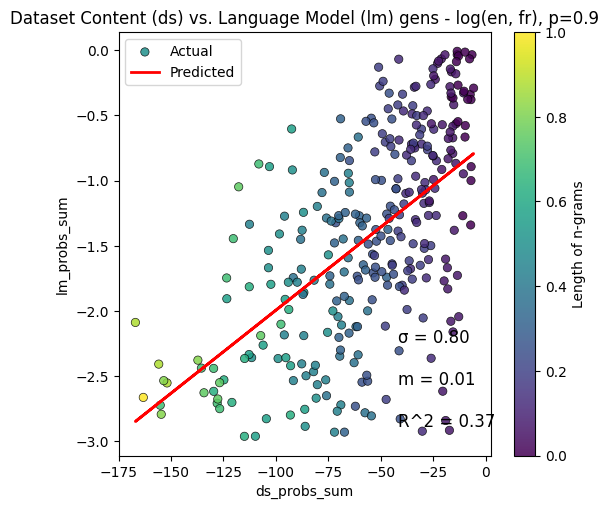

In [137]:
column_1 = 'ds_probs'
column_2 = 'lm_probs'
df = create_ngram_dataframe(doc_results_new)

# Assuming 'df' is your DataFrame containing the data
examples_pth_common_dir = os.path.dirname(examples_pth_common)
save_pth = os.path.join(examples_pth_common_dir, 'plots')
if not os.path.exists(save_pth):
    os.makedirs(save_pth)
# model, df_test, stats_test = fit_and_evaluate_linear_regression(df, column_1, column_2)
# print(df_test)

model_examples, df_examples_test, stats = fit_and_evaluate_linear_regression(df_examples, 
                                                                             'ds_probs_sum', 
                                                                             'lm_probs_sum',
                                                                             save_pth=save_pth,
                                                                             title=f'Dataset Content (ds) vs. Language Model (lm) gens - {NAME}',
                                                                             )

# # randomly permute x axis
# df_random_x = df_examples_test.copy()
# df_random_x['ds_probs_sum'] = np.random.permutation(df_random_x['ds_probs_sum'].values)
# model_random_x, df_random_x_test, stats_random_x = fit_and_evaluate_linear_regression(df_random_x, 
#                                                                                       'ds_probs_sum', 
#                                                                                       'lm_probs_sum',
#                                                                                       save_pth=model_results_pth,
#  

In [135]:
examples_pth_common_dir

'./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/2/common'

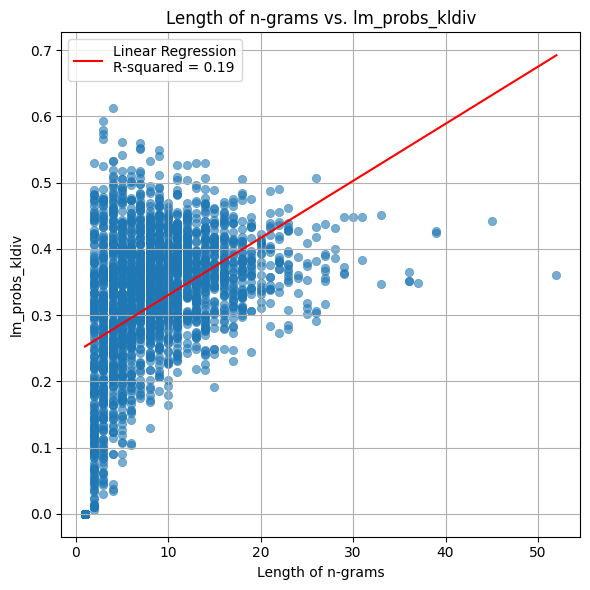

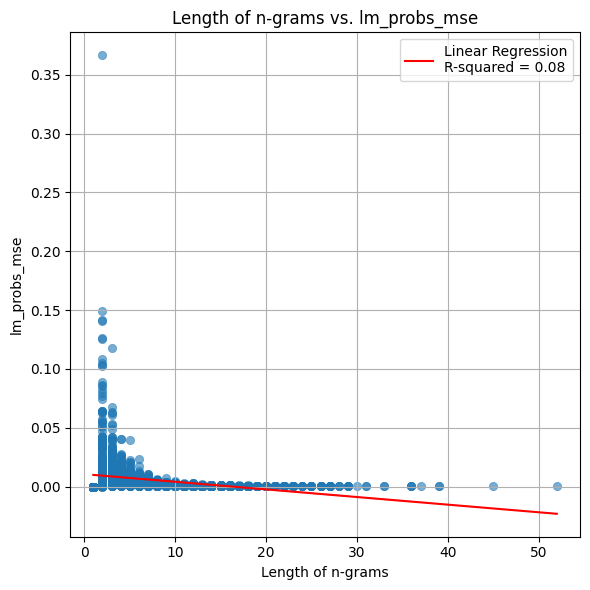

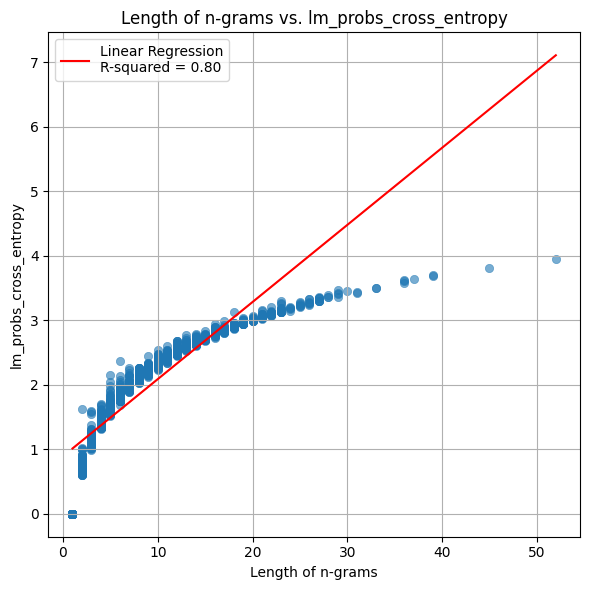

In [139]:
import seaborn as sns

def plot_len_ngrams_vs_kldiv(df, y_axis='lm_probs_kldiv', save_pth=None):
    # Ensure the necessary columns are in the DataFrame
    if 'len_ngrams' not in df or 'lm_probs_kldiv' not in df:
        raise ValueError("DataFrame must contain 'len_ngrams' and 'lm_probs_kldiv' columns.")

    plt.figure(figsize=(6, 6))
    
    # Fit a linear regression model
    model = LinearRegression()
    X = df[['len_ngrams']]
    y = df[y_axis]
    model.fit(X, y)
    
    # Make predictions
    predictions = model.predict(X)
    
    # Calculate R-squared value
    r_squared = r2_score(y, predictions)
    
    # Plot the data points
    sns.scatterplot(data=df, x='len_ngrams', y=y_axis, alpha=0.6, edgecolor=None)
    
    # Plot the regression line
    sns.lineplot(x=df['len_ngrams'], y=predictions, color='red', label=f'Linear Regression\nR-squared = {r_squared:.2f}')
    
    plt.title(f'Length of n-grams vs. {y_axis}')
    plt.xlabel('Length of n-grams')
    plt.ylabel(f'{y_axis}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save_pth is not None:
        plotname = f"len_ngrams_vs_{y_axis}_{NAME}.png"
        plt.savefig(os.path.join(save_pth, plotname))
    
    plt.show()

plot_len_ngrams_vs_kldiv(df_examples, 'lm_probs_kldiv', save_pth)
plot_len_ngrams_vs_kldiv(df_examples, 'lm_probs_mse', save_pth)
plot_len_ngrams_vs_kldiv(df_examples, 'lm_probs_cross_entropy', save_pth)
    

In [129]:
# len_ngrams_unique = df_examples['len_ngrams']

# for len_ngram in len_ngrams_unique:
#     df_len_ngram = df_examples[df_examples['len_ngrams'] == len_ngram]
#     model_examples, df_examples_test, stats = fit_and_evaluate_linear_regression(df_len_ngram, 
#                                                                                  'ds_probs_sum', 
#                                                                                  'lm_probs_sum',
#                                                                                  save_pth=model_results_pth,
#                                                                                  title=f'Dataset Content (ds) vs. Language Model (lm) gens - {NAME} - {len_ngram} ngrams')